# **MNIST - Handwritten Digit Classification**

# Setup

In [4]:
import pandas as pd
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from scipy.ndimage import shift

# Fetch the dataset

In [6]:
from sklearn.datasets import fetch_openml

In [7]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
type(mnist['data'])

numpy.ndarray

In [9]:
X, y = mnist['data'], mnist['target']

print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (70000, 784)
y shape: (70000,)


# Explore the dataset

In [11]:
# Function to plot a digit
def plot_digit(digit_arr):
    image = digit_arr.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
some_digit, some_digit_label = X[:1], y[:1]
some_digit.shape

(1, 784)

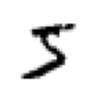

In [13]:
plt.figure(figsize=(1, 1))
plot_digit(some_digit)
plt.show()

In [14]:
some_digit_label

array(['5'], dtype=object)

In [15]:
# Function to plot some digits
def plot_some_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = int(np.ceil(len(instances) / images_per_row))

    # Append empty images to fill the end of the grid, if needed
    n_empty = (n_rows * images_per_row - len(instances))
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array into a grid containing 28x28 images
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

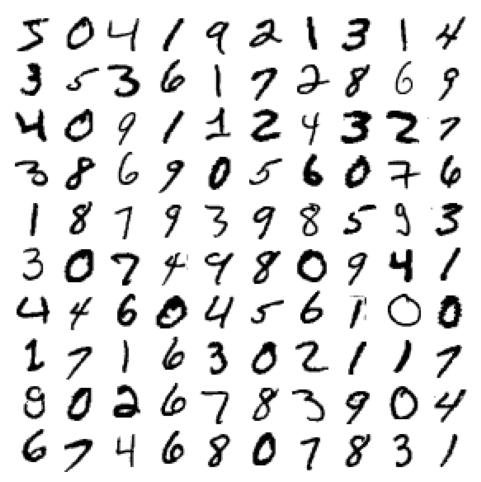

In [16]:
example_images = X[:100]
plt.figure(figsize=(6, 6))
plot_some_digits(example_images, images_per_row=10)
plt.show()

# Preprocessing

## Split the dataset

The MNIST dataset is already split into training and testing sets:
* The first 60000 instances are for training
* The last 10000 instances are for testing

In [20]:
train_size = 60000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Scale the data

SGD classifiers perform well with scaled data, therfore we'll use scaled data when training a SGD classifier

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
X_test_scaled = scaler.transform(X_test.astype('float64'))

# Model selection

## SGD classifier

In [26]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(random_state=42)

In [27]:
# Simple checking with some digit
print(f'SGD prediction: {sgd_clf.predict(some_digit)}\tLabel:{some_digit_label}')
print(f'Decision function: {sgd_clf.decision_function(some_digit).round(2)}')

SGD prediction: ['3']	Label:['5']
Decision function: [[ -52074.01  -90932.77  -20253.72   13700.41 -153621.49   -4632.87
  -107360.91  -90145.62    -980.43  -44100.09]]


In [28]:
# Check model accuracy
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Random forest classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Simple checking with some digit
print(f'Random forest prediction: {forest_clf.predict(some_digit)}\tLabel:{some_digit_label}')
print(f'Predicted probabilities: {forest_clf.predict_proba(some_digit).round(2)}')

Random forest prediction: ['5']	Label:['5']
Predicted probabilities: [[0.   0.   0.01 0.08 0.   0.9  0.   0.   0.   0.01]]


In [32]:
# Check model accuracy
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9646 , 0.96255, 0.9666 ])

## K Neighbors classifier

In [251]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [253]:
# Simple checking with some digit
print(f'SGD prediction: {forest_clf.predict(some_digit)}\tLabel:{some_digit_label}')
print(f'Predicted probabilities: {forest_clf.predict_proba(some_digit).round(2)}')

SGD prediction: ['5']	Label:['5']
Predicted probabilities: [[0.   0.   0.01 0.08 0.   0.9  0.   0.   0.   0.01]]


In [41]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9676 , 0.9671 , 0.96755])

In [42]:
knn_clf_preds = cross_val_predict(knn_clf, X_train, y_train, cv=3, method='predict')

knn_clf_precision = precision_score(y_train, knn_clf_preds, average='weighted').round(4)
knn_clf_recall = recall_score(y_train, knn_clf_preds, average='weighted').round(4)
knn_clf_f1 = f1_score(y_train, knn_clf_preds, average='weighted').round(4)

print(f'KNeighborsClassifier: Precision {knn_clf_precision}\tRecall {knn_clf_recall}\tF1-score {knn_clf_f1}')

KNeighborsClassifier: Precision 0.9677	Recall 0.9674	F1-score 0.9673


KNeighborsClassifier seems to be the best among the tested models, Therefore we'll use that

# Hyperparameter tuning

Accuracy of the KNeighborsClassifer before tuning:

In [274]:
base_accuracy = knn_clf.score(X_train, y_train)
print(f'Score before tuning the KNeighborsClassifier: {round(base_accuracy, 4)}')

Score before tuning the KNeighborsClassifier: 0.9819


In [45]:
# Find the best parameters for the KNeighborsClassifier
# First, fiit a subset of the training set to speed up the process
param_grid = [{'n_neighbors': [3, 4, 5, 6, 7], 'weights': ['uniform', 'distance']}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}])

In [155]:
# GridSearchCV results ranked by the rank test score
grid_search_df = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
grid_search_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.018053,0.001228,0.377403,0.021712,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.9440,0.9500,0.9495,0.9380,0.9395,0.9442,0.004946,1
1,0.019508,0.002039,0.275163,0.010028,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.9415,0.9470,0.9505,0.9370,0.9360,0.9424,0.005616,2
5,0.022377,0.002695,0.398861,0.011704,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.9380,0.9460,0.9515,0.9350,0.9350,0.9411,0.006576,3
2,0.019887,0.002872,0.386513,0.014242,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",0.9360,0.9460,0.9510,0.9355,0.9340,0.9405,0.006753,4
7,0.019009,0.001499,0.390917,0.009459,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.9385,0.9455,0.9505,0.9370,0.9305,0.9404,0.006946,5
0,0.020605,0.002118,0.314275,0.007513,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.9395,0.9425,0.9475,0.9335,0.9345,0.9395,0.005177,6
9,0.022734,0.003851,0.397092,0.013347,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.9360,0.9440,0.9455,0.9360,0.9285,0.9380,0.006173,7
4,0.025244,0.006184,0.446470,0.037426,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.9330,0.9420,0.9485,0.9335,0.9315,0.9377,0.006531,8
6,0.023613,0.004458,0.420106,0.014140,6,uniform,"{'n_neighbors': 6, 'weights': 'uniform'}",0.9325,0.9385,0.9470,0.9360,0.9275,0.9363,0.006501,9
8,0.029407,0.008337,0.436039,0.019735,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.9315,0.9430,0.9445,0.9350,0.9260,0.9360,0.006964,10


In [46]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [47]:
grid_search.best_score_

0.9441999999999998

In [237]:
# Fit the full dataset to the best model
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_train, y_train)
tuned_accuracy

1.0

__Important:__
<br>
The model has overfitted, it has a perfect accuracy (100%) which is not realistic for a machine learning model, therefore the model need to be regularized
<br><br>
*Let's try regularizing the model*

In [278]:
# Low randked param combination received from the GridSearchCV result
# This combination will be used to regularize the model
params_reg = grid_search_df[grid_search_df['rank_test_score'] == 4]['params'].values[0]
params_reg

{'n_neighbors': 4, 'weights': 'uniform'}

In [328]:
knn_clf = KNeighborsClassifier(**params_reg)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [336]:
tuned_accuracy_reg = knn_clf.score(X_train, y_train)
round(tuned_accuracy_reg, 4)

0.983

In [331]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96625, 0.9664 , 0.96725])

The regularized model seems good:
> Model accuracy is higher than the base model.
> <br>
> Cross validation scores also look good.

# Error Analysis

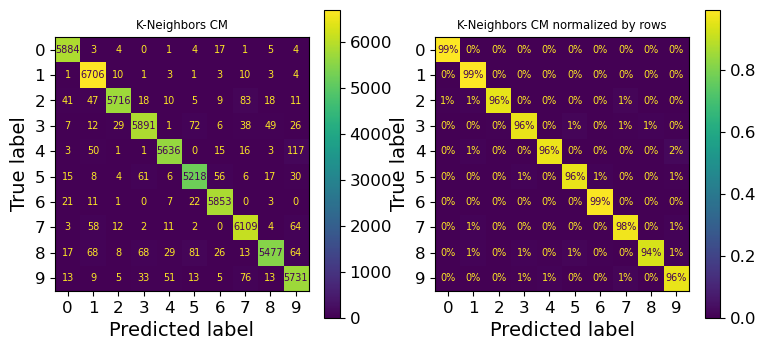

In [291]:
# Confusion matrix
figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=7)
ConfusionMatrixDisplay.from_predictions(y_train, knn_clf_preds, ax=axs[0])
axs[0].set_title('K-Neighbors CM')

plt.rc('font', size=7)
ConfusionMatrixDisplay.from_predictions(y_train, knn_clf_preds, ax=axs[1], normalize='true',
                                        values_format='.0%')
axs[1].set_title('K-Neighbors CM normalized by rows')
plt.show()

According to the confusion matrix, the tuned KNeighborsClassifier seems to perform really well

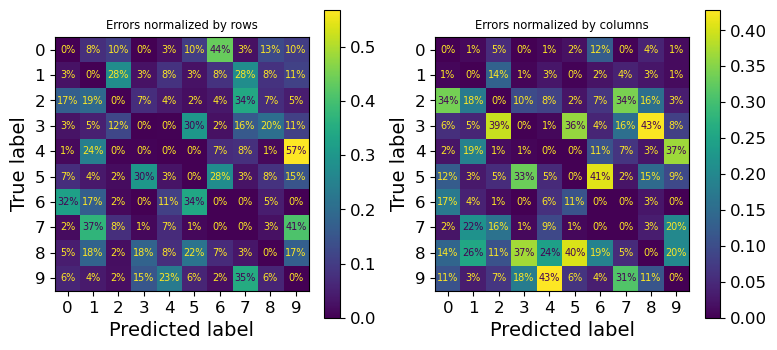

In [293]:
# Normalize the errors
knn_clf_sample_weights = (knn_clf_preds != y_train)

figs, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=7)
ConfusionMatrixDisplay.from_predictions(y_train, knn_clf_preds, ax=axs[0],
                                       sample_weight=knn_clf_sample_weights,
                                       normalize='true', values_format='.0%')
axs[0].set_title('Errors normalized by rows')

plt.rc('font', size=7)
ConfusionMatrixDisplay.from_predictions(y_train, knn_clf_preds, ax=axs[1],
                                        sample_weight=knn_clf_sample_weights,
                                        normalize='pred', values_format='.0%')
axs[1].set_title('Errors normalized by columns')
plt.show()

__Observations:__
<br>
* Digit 4 in partucular seems to be largely misclassified as digit 9:
> Out of false negatives for digit 4, 57% of them are classified as digit 9.

* Digit 0 also seems to be considerably misclassified as digit 6:
> 44%

* The model seems to predict digit 8 as instances of other classes a considerbale number of times:
> Specially, digit 8 makes up 40% of the digit 5's false positives and 37% of the number 3's false positives.
> <br>

* Digit 9 also makes up 43% of digit 4's flase positives.
* In general most of the classes have more than one class that makes up >30% of its false positives.

### Visualize some of the largely misclassified classes

In [296]:
def plot_misclassified(digit_matrix):
    for idx, a in enumerate(digit_matrix):
        plt.subplot(2, 2, idx+1)
        image = a[:16].reshape(4, 4, 28, 28).transpose(0, 2, 1, 3).reshape(4 * 28, 4 * 28)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

#### 4s and 9s

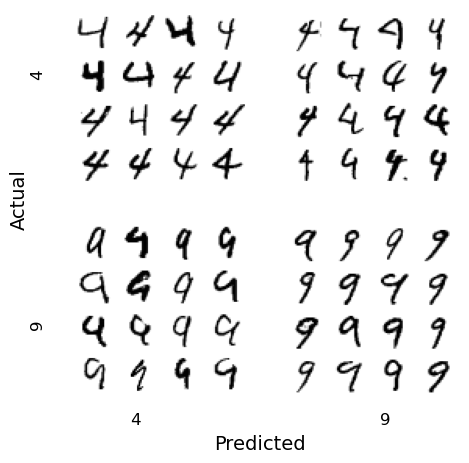

In [298]:
cl_4, cl_9 = '4', '9'

X_44 = X_train[(y_train == cl_4) & (knn_clf_preds == cl_4)]
X_49 = X_train[(y_train == cl_4) & (knn_clf_preds == cl_9)]
X_94 = X_train[(y_train == cl_9) & (knn_clf_preds == cl_4)]
X_99 = X_train[(y_train == cl_9) & (knn_clf_preds == cl_9)]

fig = plt.figure(figsize=(5, 5))
plot_misclassified([X_44, X_49, X_94, X_99])

fig.text(0.5, 0.0, 'Predicted', ha='center', fontsize=14)
fig.text(0.25, 0.05, '4', ha='center', fontsize=12)
fig.text(0.75, 0.05, '9', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'Actual', va='center', rotation='vertical', fontsize=14)
fig.text(0.04, 0.25, '9', va='center', rotation='vertical', fontsize=12)
fig.text(0.04, 0.75, '4', va='center', rotation='vertical', fontsize=12)

plt.show()

#### 0s and 6s

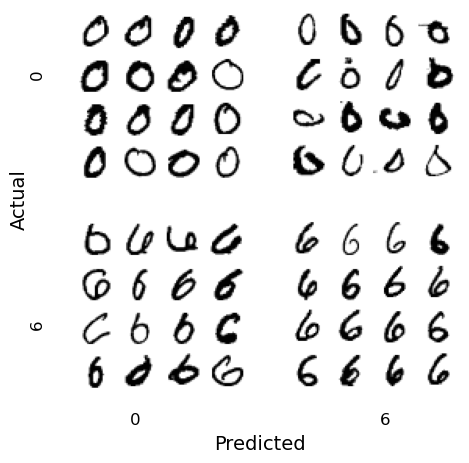

In [300]:
cl_0, cl_6 = '0', '6'

X_00 = X_train[(y_train == cl_0) & (knn_clf_preds == cl_0)]
X_06 = X_train[(y_train == cl_0) & (knn_clf_preds == cl_6)]
X_60 = X_train[(y_train == cl_6) & (knn_clf_preds == cl_0)]
X_66 = X_train[(y_train == cl_6) & (knn_clf_preds == cl_6)]

fig = plt.figure(figsize=(5, 5))
plot_misclassified([X_00, X_06, X_60, X_66])

fig.text(0.5, 0.0, 'Predicted', ha='center', fontsize=14)
fig.text(0.25, 0.05, '0', ha='center', fontsize=12)
fig.text(0.75, 0.05, '6', ha='center', fontsize=12)
fig.text(0.0, 0.5, 'Actual', va='center', rotation='vertical', fontsize=14)
fig.text(0.04, 0.25, '6', va='center', rotation='vertical', fontsize=12)
fig.text(0.04, 0.75, '0', va='center', rotation='vertical', fontsize=12)

plt.show()

# Data Augmentation

Augment the training data to imporve the accuracy of the model by making shifted copies of the images

In [303]:
# Function to shif the images
def shift_image(image_arr, vertical, horizontal):
    shifted_image = shift(image_arr.reshape(28, 28), (vertical, horizontal), 
                          cval=0, mode='constant')
    return shifted_image.reshape(-1)

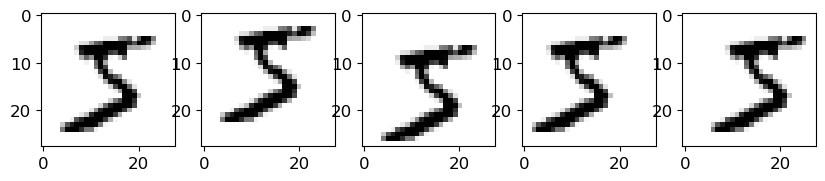

In [362]:
# Test the shifting process
image_arr = X_train[0]

shifted_u = shift_image(image_arr, -2, 0)
shifted_d = shift_image(image_arr, 2, 0)
shifted_l = shift_image(image_arr, 0, -2)
shifted_r = shift_image(image_arr, 0, 2)

plt.figure(figsize=(10, 2))
plt.subplot(151); plot_digit(image_arr); plt.axis(True)
plt.subplot(152); plot_digit(shifted_u); plt.axis(True)
plt.subplot(153); plot_digit(shifted_d); plt.axis(True)
plt.subplot(154); plot_digit(shifted_l); plt.axis(True)
plt.subplot(155); plot_digit(shifted_r); plt.axis(True)
plt.show()

In [364]:
# Augment all the images in the training set
X_train_augmented = [x for x in X_train]
y_train_augmented = [y for y in y_train]

for x, y in zip(X_train, y_train):
    for dx, dy in [(-2, 0), (2, 0), (0, -2), (0, 2)]:
        X_train_augmented.append(shift_image(x, dy, dx))
        y_train_augmented.append(y)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [365]:
# Shuffle the indices
shuffled_indices = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffled_indices]
y_train_augmented = y_train_augmented[shuffled_indices]

In [366]:
# Train the model using the augmented data
knn_clf = KNeighborsClassifier(**params_reg)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4)

In [370]:
augmented_accuracy = knn_clf.score(X_train, y_train)
augmented_accuracy

0.98315

In [371]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96625, 0.9664 , 0.96725])

__Insight:__
<br>
Apart from the minor improvement we get in the model accuracy (0.015%) there doesn't seem to be any improvement after the data augmentation by shifting the images
> The cross validation scores after tuning the hyperparameters ([0.96625, 0.9664 , 0.96725]) is the same as the cross validation scores after training on the augmented data set

# Testing

In [377]:
test_accuracy = knn_clf.score(X_test, y_test)
test_accuracy

0.9678

In [389]:
cross_val_score(knn_clf, X_test, y_test, cv=5, scoring='accuracy')

array([0.922, 0.927, 0.943, 0.959, 0.961])

In [391]:
knn_clf_preds_test = cross_val_predict(knn_clf, X_test, y_test, cv=3, method='predict')

knn_clf_precision = precision_score(y_test, knn_clf_preds_test, average='weighted').round(4)
knn_clf_recall = recall_score(y_test, knn_clf_preds_test, average='weighted').round(4)
knn_clf_f1 = f1_score(y_test, knn_clf_preds_test, average='weighted').round(4)

print(f'Testing results: Precision {knn_clf_precision}\tRecall {knn_clf_recall}\tF1-score {knn_clf_f1}')

Testing results: Precision 0.9365	Recall 0.9354	F1-score 0.9351


__Conclusion:__
<br>
Overall, the model's performance seems good:
> Both the training and testing accuracy is high, and also the testing accuracy is close to the training accuracy.
<br>
> The cross validation scores for the training set is consistent.

<br>
However, the inconsistency between the cross validation scores for the testing set indicates that the model has overfitted to some digree.

> The lower precision, recall and f1 scores for the testing set compared to the testing set also point to overfitting.